In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import sys
sys.path.append("..")
from utils.utils import trans_cutout
import seaborn as sns

In [2]:
df = pd.read_csv("../data/semifield-cutouts/TX_2023-01-13/TX_2023-01-13.csv")
df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
df["date"] = df.batch_id.str.split("_", expand=False).str[1]
df["common_name"] = np.where(df.common_name == "Common lambsquarters", "Lambsquarter", df.common_name)
df["temp_path"] = "../data/semifield-cutouts/" + df["cutout_path"]

In [9]:
features = [
    "blob_home", "image_id", "cutout_num", "datetime", "cutout_id",
    "is_primary", "extends_border", "r_count", "r_mean", "r_std", "r_min",
    "r_25%", "r_50%", "r_75%", "r_max", "r_variance", "r_skewness",
    "r_kurtosis", "g_count", "g_mean", "g_std", "g_min", "g_25%", "g_50%",
    "g_75%", "g_max", "g_variance", "g_skewness", "g_kurtosis", "b_count",
    "b_mean", "b_std", "b_min", "b_25%", "b_50%", "b_75%", "b_max",
    "b_variance", "b_skewness", "b_kurtosis", "area", "common_name",
    "growth_habit", "duration", "category", "hex", "r", "g", "b", "area_bbox",
    "area_convex", "axis_major_length", "axis_minor_length", "centroid0",
    "centroid1", "eccentricity", "extent", "solidity", "perimeter", "is_green",
    "green_sum", "exg_sum", "blur_effect", "num_components", "state_id"
]


In [16]:
named_featdata = df.loc[:, features]
multfeatdf = named_featdata.groupby(["common_name"]).describe().reset_index()#names=["common_name"])
multfeatdf = multfeatdf[multfeatdf["common_name"]!="colorchecker"]
# print(multfeatdf)
# savedir = "/home/weedsci/matt/SemiF-AnnotationPipeline/assets"
# multfeatdf.to_csv(f"{savedir}/describe_all_cutouts.csv", index=False)
multfeatdf
multfeatdf.columns = multfeatdf.columns.to_flat_index()
multfeatdf.columns = ['_'.join(x) for x in multfeatdf.columns.get_level_values(0)]
for i in multfeatdf.columns:
    print(i)


common_name_
cutout_num_count
cutout_num_mean
cutout_num_std
cutout_num_min
cutout_num_25%
cutout_num_50%
cutout_num_75%
cutout_num_max
r_count_count
r_count_mean
r_count_std
r_count_min
r_count_25%
r_count_50%
r_count_75%
r_count_max
r_mean_count
r_mean_mean
r_mean_std
r_mean_min
r_mean_25%
r_mean_50%
r_mean_75%
r_mean_max
r_std_count
r_std_mean
r_std_std
r_std_min
r_std_25%
r_std_50%
r_std_75%
r_std_max
r_min_count
r_min_mean
r_min_std
r_min_min
r_min_25%
r_min_50%
r_min_75%
r_min_max
r_25%_count
r_25%_mean
r_25%_std
r_25%_min
r_25%_25%
r_25%_50%
r_25%_75%
r_25%_max
r_50%_count
r_50%_mean
r_50%_std
r_50%_min
r_50%_25%
r_50%_50%
r_50%_75%
r_50%_max
r_75%_count
r_75%_mean
r_75%_std
r_75%_min
r_75%_25%
r_75%_50%
r_75%_75%
r_75%_max
r_max_count
r_max_mean
r_max_std
r_max_min
r_max_25%
r_max_50%
r_max_75%
r_max_max
r_variance_count
r_variance_mean
r_variance_std
r_variance_min
r_variance_25%
r_variance_50%
r_variance_75%
r_variance_max
r_skewness_count
r_skewness_mean
r_skewness_std
r_ske

Text(0.5, 0.98, 'Number of Cutouts (sub-images) by Batch')

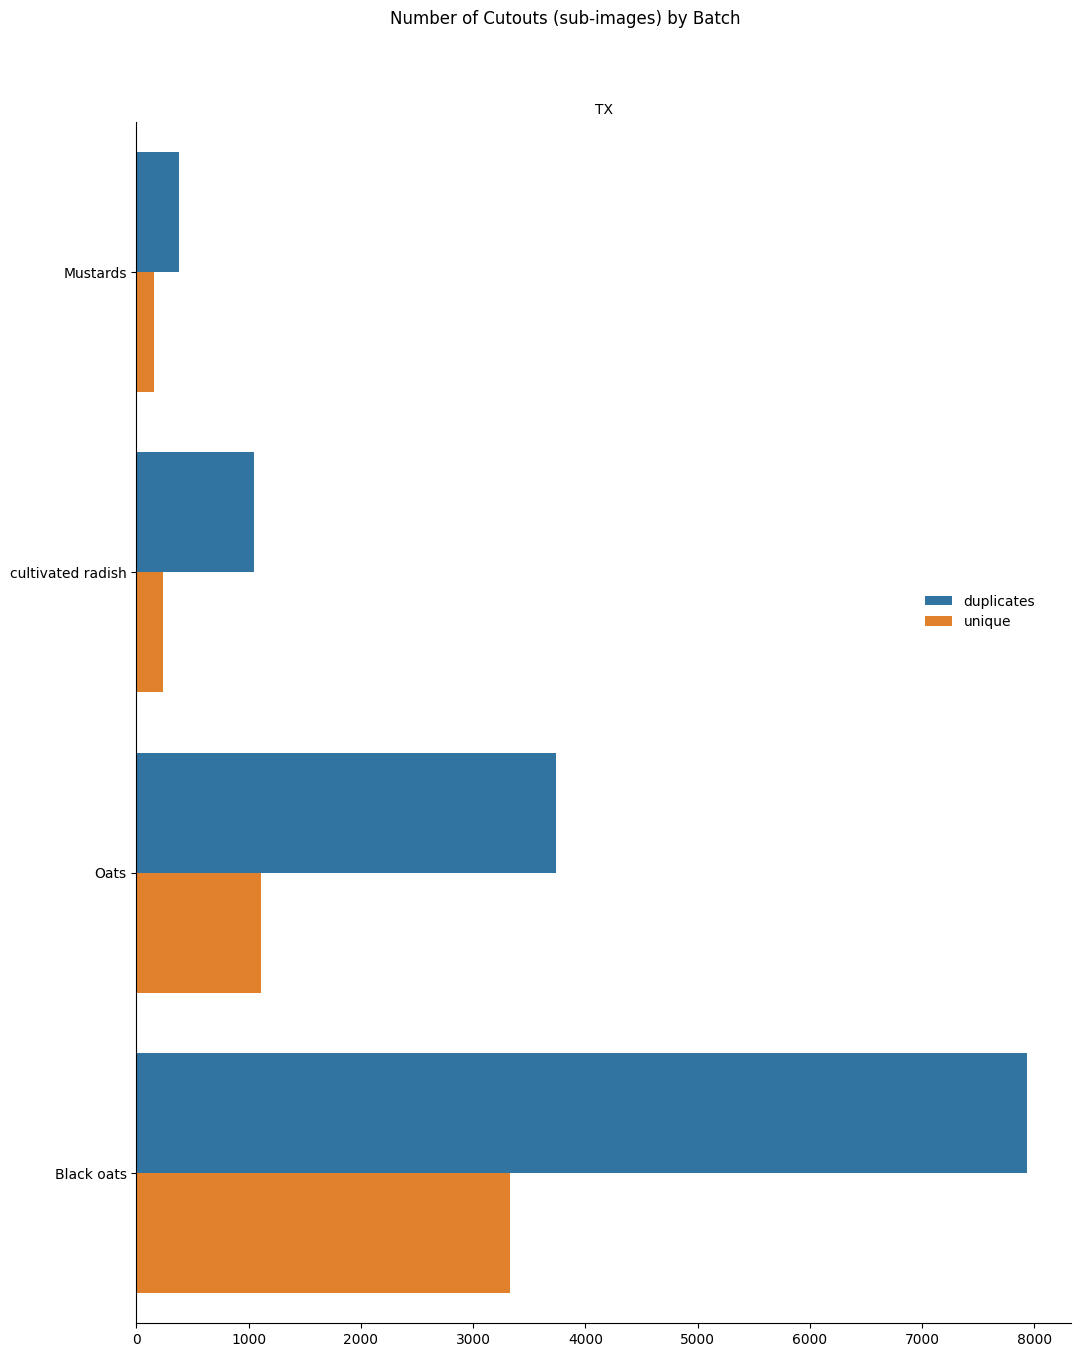

In [24]:
batch = "TX_2023-01-13"
c = df.groupby(["common_name", "state_id", "is_primary"]).cutout_id.count().reset_index().sort_values("cutout_id")
c = c[c["common_name"]!="colorchecker"]
g = sns.catplot(
    data=c,
    x="cutout_id",
    y="common_name",
    hue="is_primary",
    orient="horizontal",
    col="state_id",
    sharey=False,
    kind="bar",
    aspect=.8,
    height=14
)
g.set(xlabel="", ylabel="")
g.set_titles(col_template="{col_name}")
g._legend.set_title("")
# replace labels
new_labels = ['duplicates', 'unique']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(g, "center right", bbox_to_anchor=(.9, .55), frameon=False)

g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Number of Cutouts (sub-images) by Batch')
# g.savefig(f"../assets/Cutouts_for_batch{batch}.png", dpi=300)

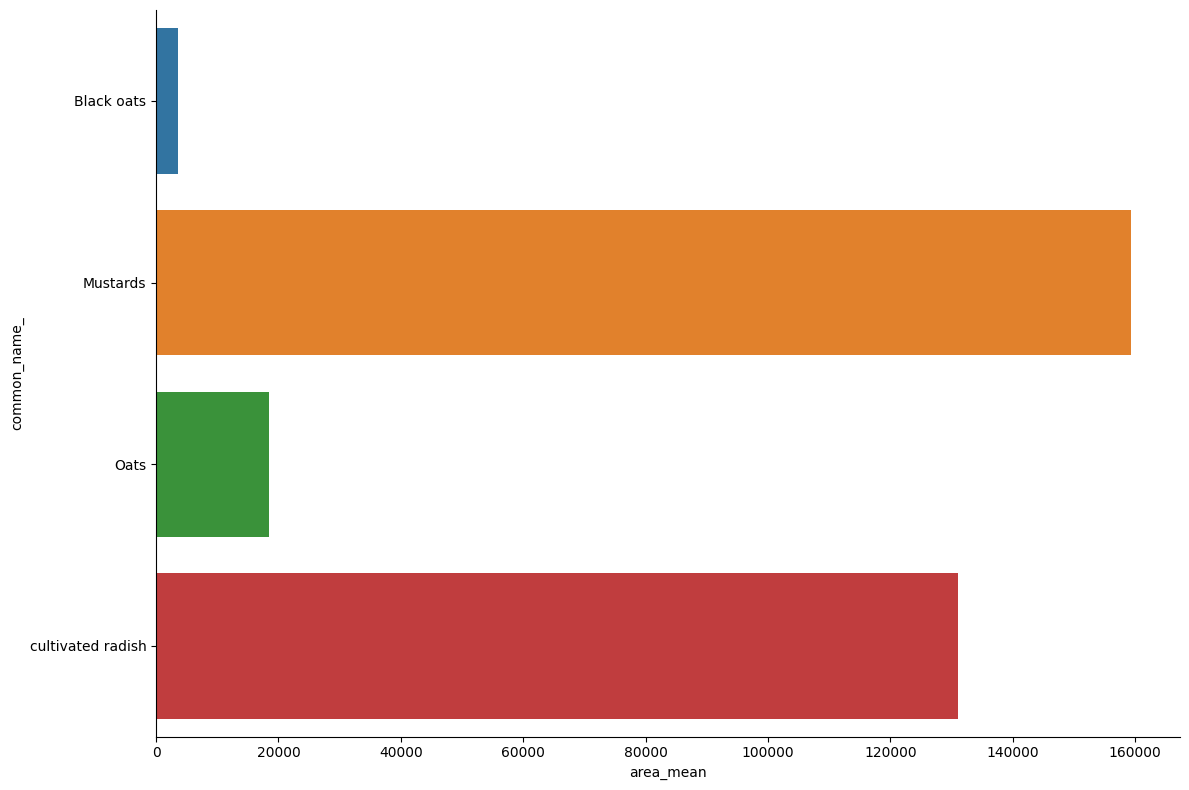

In [17]:
sns.catplot(
    data=multfeatdf, x="area_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

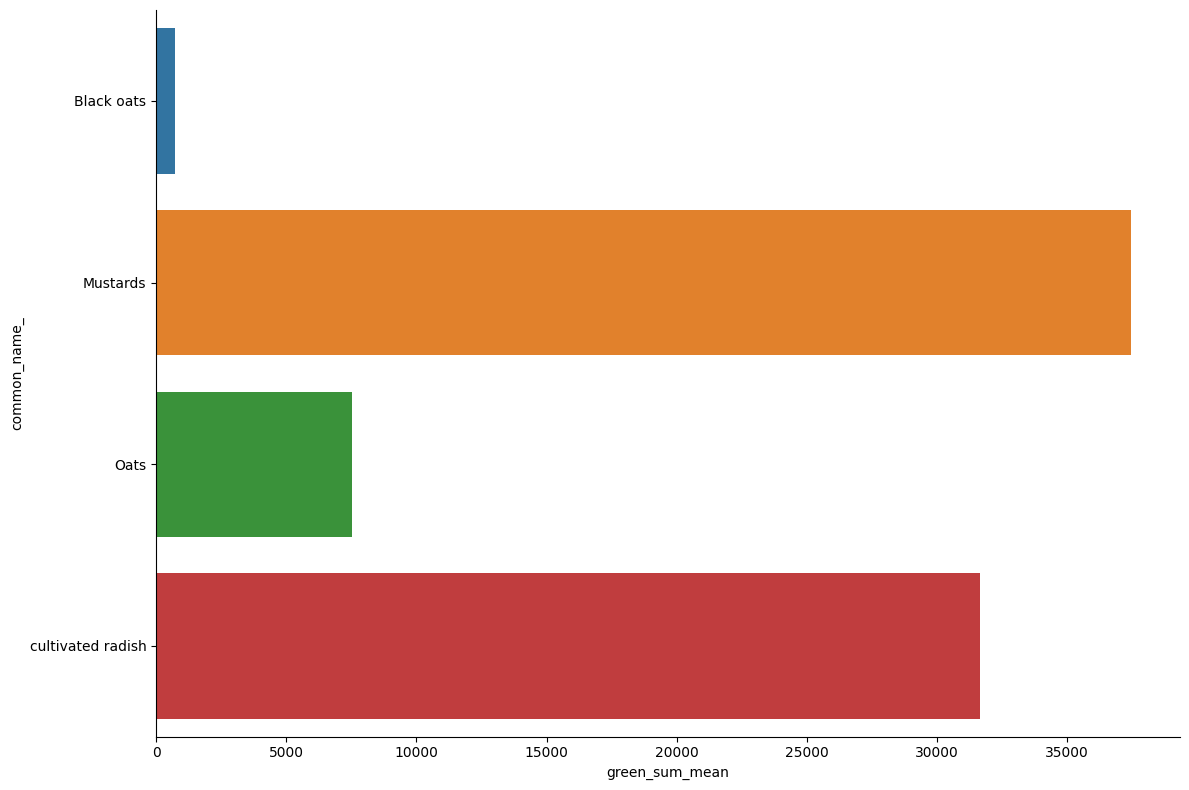

In [18]:

sns.catplot(
    data=multfeatdf, x="green_sum_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

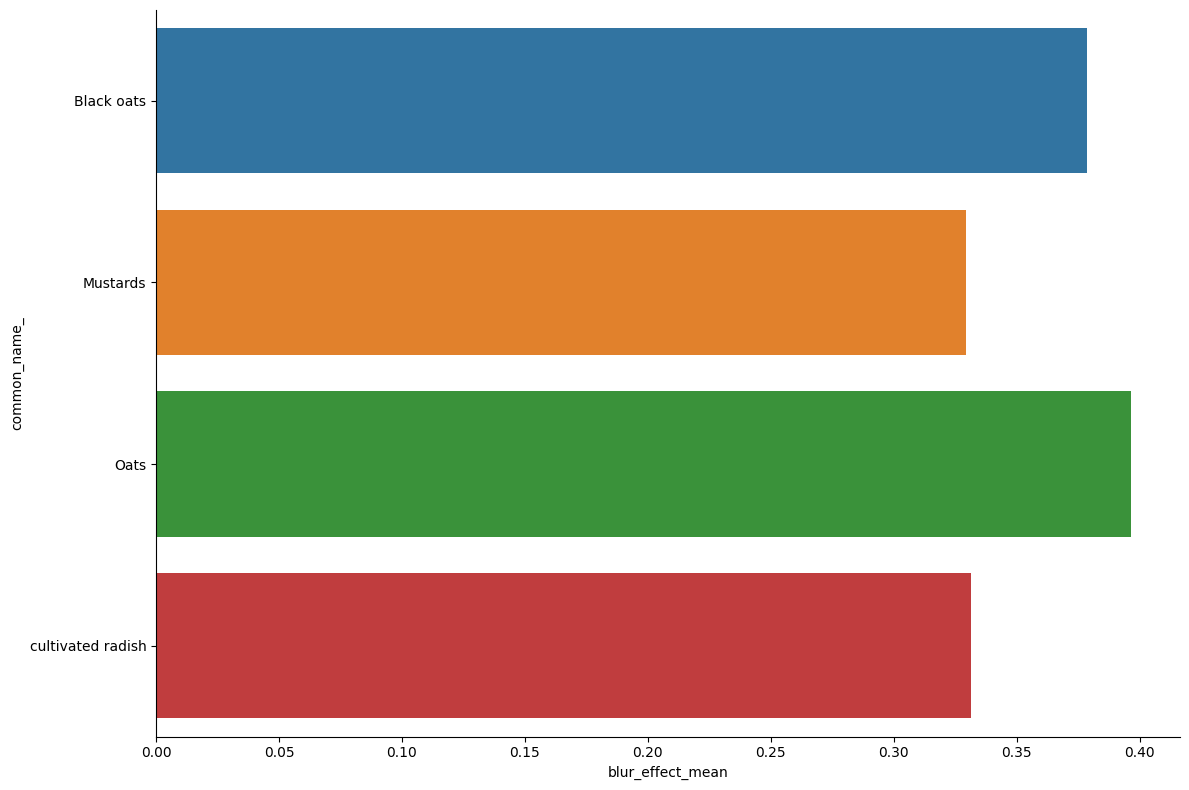

In [26]:

sns.catplot(
    data=multfeatdf, x="blur_effect_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

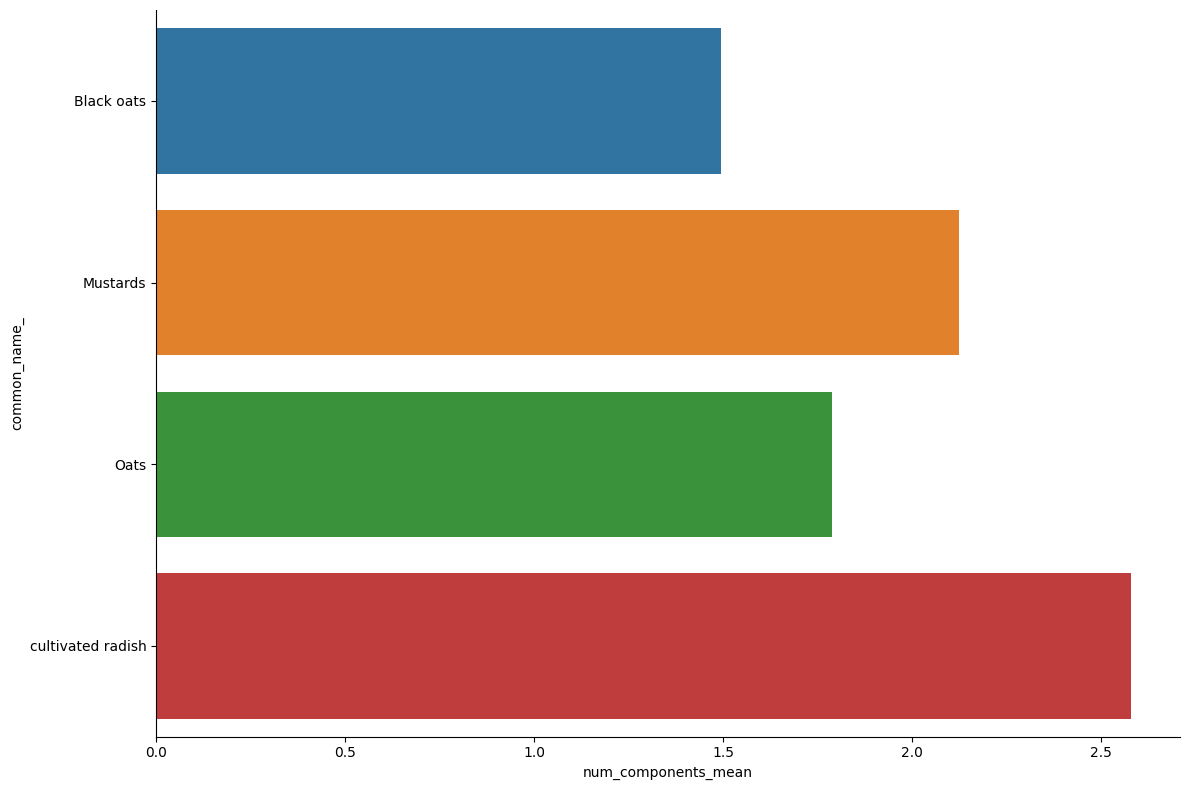

In [28]:
sns.catplot(
    data=multfeatdf, x="num_components_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

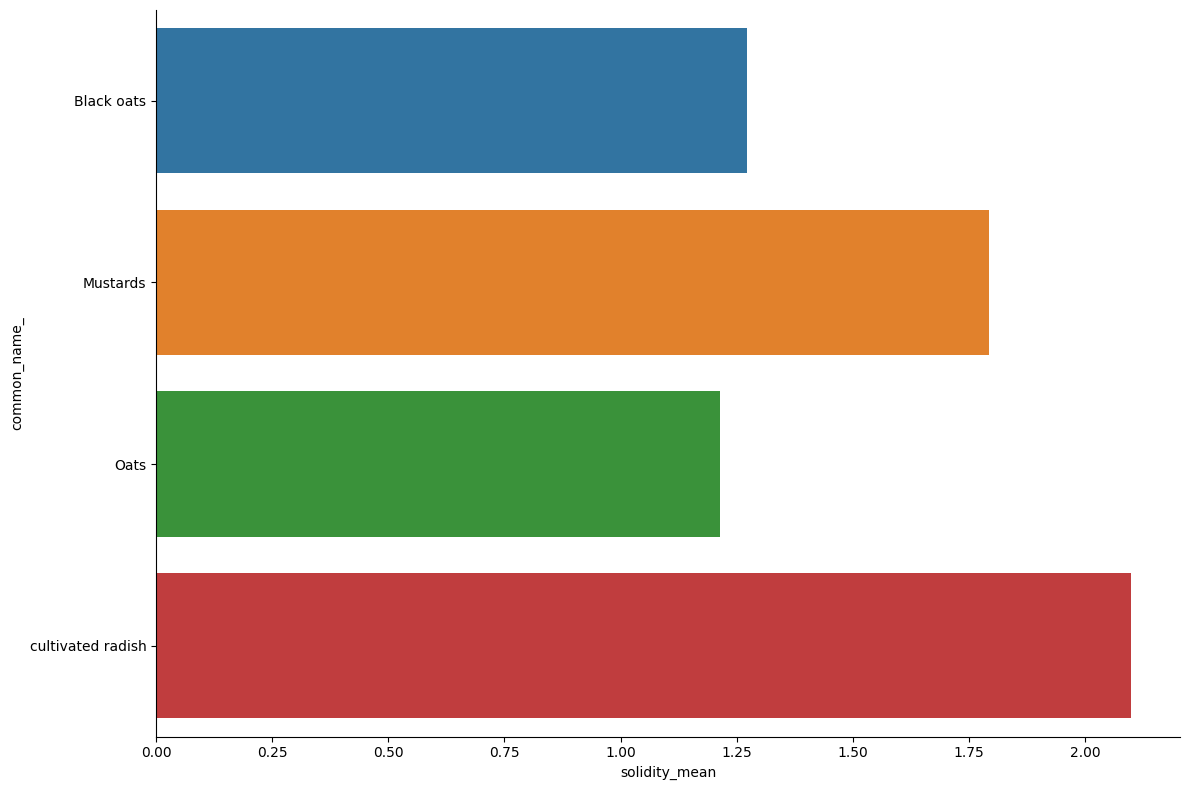

In [29]:
sns.catplot(
    data=multfeatdf, x="solidity_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")

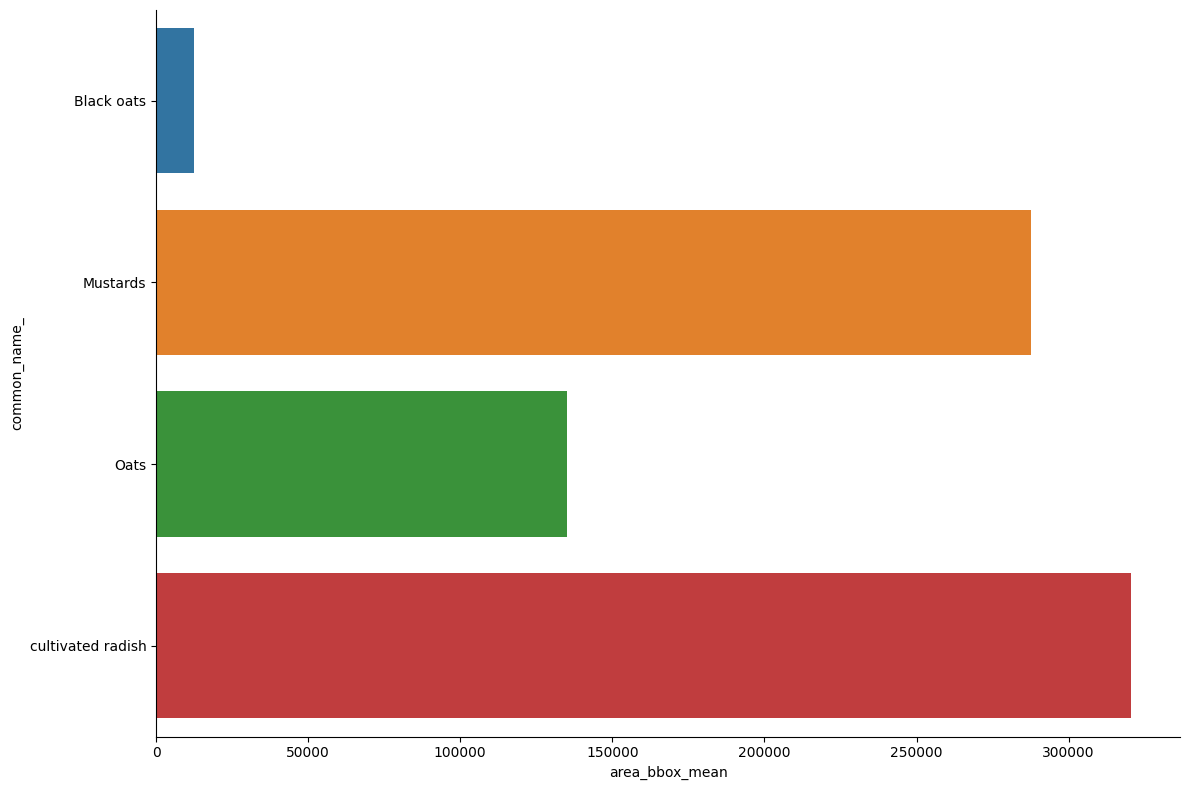

In [42]:
sns.catplot(
    data=multfeatdf, x="area_bbox_mean", y="common_name_",height=8, aspect=1.5,
    kind="bar")